# Case Study 2A
## Understanding Customer Engagement with Regression

Data Source:

https://www.ibm.com/communities/analytics/watson-analytics-blog/marketing-customer-value-analysis/

We will explore a dataset from IBM Watson that contains marketing data from an auto insurer. This time, the data came from a multi-faceted marketing campaign (calls, web, and other sales channels) and we are going to explore how customers respond to (engage with) advertisements as a function of their data.

In [26]:
%load_ext autoreload
%autoreload 2

import helpers as hp

import statsmodels.formula.api as sm
import pandas as pd
import numpy as np
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [3]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


We have quite a few interesting columns to explore here. We know roughly where the customers live, their 'lifetime value' (an estimate of the total revenue the insurer will generate from them), various things about their insurance coverage (type of car, claims, policy type, etc.), and other information such as employment and gender.

First, let's turn our binary class (response or no response) into a number.

In [7]:
df['Engaged'] = hp.binary_process(df, 'Response')

In [8]:
df[['Engaged', 'Response']].head(6)

,Engaged,Response
0,0,No
1,0,No
2,0,No
3,0,No
4,0,No
5,1,Yes


Let's look at our total engagement rate for this entire dataset.

In [9]:
hp.get_ratio(df, 'Engaged')

0.14320122618786948

Okay, so 14% of the customers we reached out to have engaged with the advertisement with some kind of response.

Let's segment along the Sales Channel.

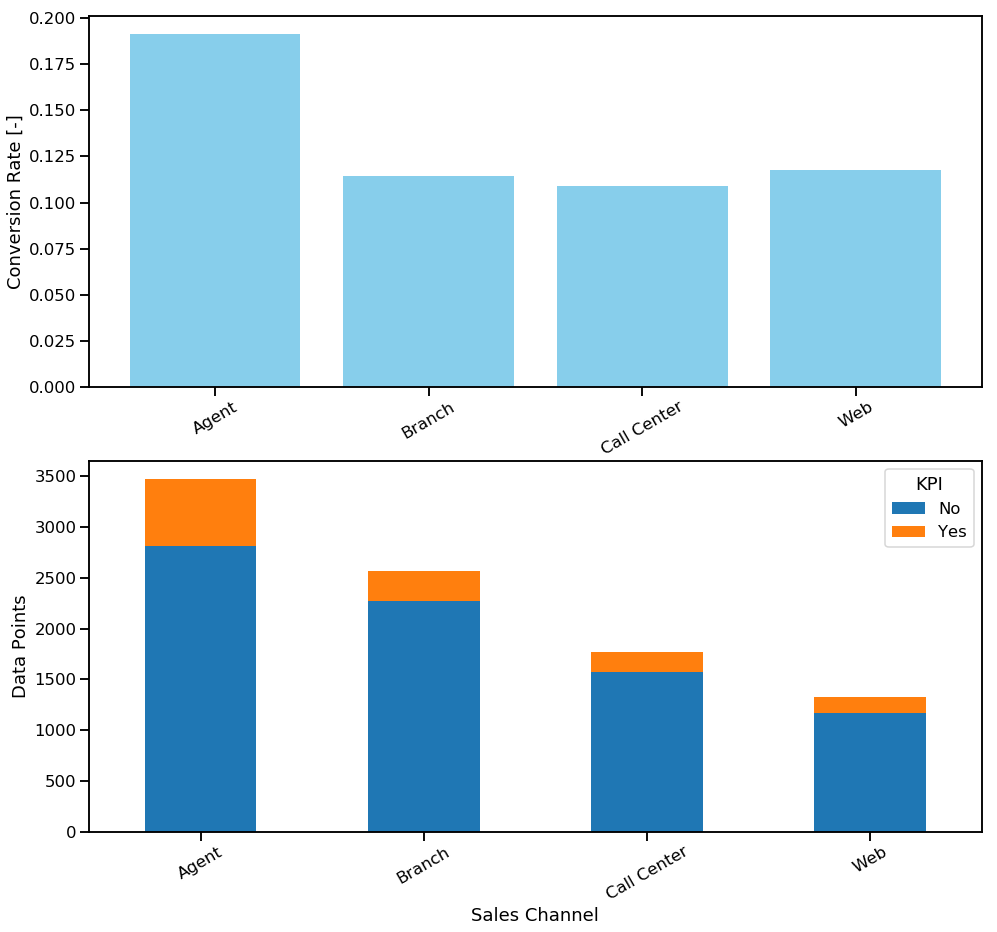

In [27]:
fig, ax = hp.bar_ratios_and_bins(df, 'Engaged', 'Sales Channel')

In [23]:
# TODO: An annotated multi-series bar chart
# Nos can go inside the bar, yes's can go above bar (% and num)

One thing we can learn from this data is that the conversion rate is largest when agents deliver the marketing message. This makes sense since an agent may have a report with the customer as opposed to someone at the Branch or at a call center. The conversion rates for the other three sales channels are more or less the same. 

What subset of the customers were subject to this marketing campaign? This will give us some context on the engagement rates.

First, let's look at a summary of the numeric columns.

In [24]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Engaged
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.940475,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,0.143201
std,6870.967608,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,0.350297
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,0.000000
25%,3994.251794,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,0.000000
50%,5780.182197,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,0.000000
75%,8962.167041,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,0.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,1.000000


The mean Customer Lifetime Value (CLV) is about 8000. Interestingly, the median is much lower - most of the values are concentrated below the mean. Some extremely high values (like the max of 83,000) skew the mean upwards.

We can look at the skewness of the numerical features in more detail, but we'll proceed to a regression analysis instead.

## Regression Analysis
We'll use the statsmodels package to create a Logistic Regression model which will help us understand the importance of each feature. Right now, we'll just use the numerical features.

In [31]:
continuous_vars = list(df.describe().columns)
continuous_vars = [var for var in continuous_vars if 'Engaged'
                   not in var]

In [32]:
logit = sm.Logit(df['Engaged'],
                df[continuous_vars])
logit_fit = logit.fit()
logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.421189
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9126
Method:                           MLE   Df Model:                            7
Date:                Tue, 14 May 2019   Pseudo R-squ.:                -0.02546
Time:                        12:26:27   Log-Likelihood:                -3847.1
converged:                       True   LL-Null:                       -3751.6
                                        LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.741e-06   5.04e-06     -1.337      0.181   -1.66e-05    3.14e-06
Income                        -2.857e-06   1.03e-06     -2.766      0.006   -4.88e-06   -8.33e-07
Monthly Premium Auto             -0.0084      0.001     -6.889      0.000      -0.011      -0.006
Months Since Last Claim          -0.0202      0.003     -7.238      0.000      -0.026      -0.015
Months Since Policy Inception    -0.0060      0.001     -6.148      0.000      -0.008      -0.004
Number of Open Complaints        -0.0829      0.034     -2.424      0.015      -0.150      -0.016
Number of Policies               -0.0810      0.013     -6.356      0.000      -0.106      -0.056
Total Claim Amount                0.0001      0.000      0.711      0.477      -0.000       0.000
=================================================================================================
"""

The above summary of a fitted Logistic Regression model gives us a lot of information. We have a column of coefficents, standard error, z scores, p-values, confidence intervals.

Lower p-values mean that the relationship between the feature and the engagement is more statistically significant. A popular cut-off p-value for "statistical significance" is 0.05. We can see that 6 of our 8 features show p-values less than 0.05 and are therefore statistically significant in this context. 

Now let's encode the categorical variables and include them in the regression.

In [33]:
# Factorize binary class
gender_values, _ = df['Gender'].factorize()  # 0 or 1 now

# Label encode education (ordinal)
edu_cat = pd.Categorical(df['Education'],
                         categories=['High School or Below',
                                     'Bachelor',
                                     'College',
                                     'Master',
                                     'Doctor']).codes
df['Gender_Factorized'] = gender_values
df['Education_Factorized'] = edu_cat

new_vars = continuous_vars + ['Gender_Factorized',
                              'Education_Factorized']

In [34]:
logit2 = sm.Logit(df['Engaged'], df[new_vars])
logit2_fit = logit2.fit()
logit2_fit.summary()

Optimization terminated successfully.
         Current function value: 0.420810
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9124
Method:                           MLE   Df Model:                            9
Date:                Tue, 14 May 2019   Pseudo R-squ.:                -0.02454
Time:                        12:41:03   Log-Likelihood:                -3843.7
converged:                       True   LL-Null:                       -3751.6
                                        LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.909e-06   5.03e-06     -1.373      0.170   -1.68e-05    2.96e-06
Income                         -2.59e-06   1.04e-06     -2.494      0.013   -4.63e-06   -5.55e-07
Monthly Premium Auto             -0.0081      0.001     -6.526      0.000      -0.011      -0.006
Months Since Last Claim          -0.0194      0.003     -6.858      0.000      -0.025      -0.014
Months Since Policy Inception    -0.0057      0.001     -5.827      0.000      -0.008      -0.004
Number of Open Complaints        -0.0813      0.034     -2.376      0.017      -0.148      -0.014
Number of Policies               -0.0781      0.013     -6.114      0.000      -0.103      -0.053
Total Claim Amount                0.0001      0.000      0.943      0.346      -0.000       0.000
Gender_Factorized                -0.1500      0.058     -2.592      0.010      -0.263      -0.037
Education_Factorized             -0.0070      0.027     -0.264      0.792      -0.059       0.045
=================================================================================================
"""

The additional information here is that engagement is quite sensitive to gender, while education level doesn't seem to offer additional useful information for the model. Let's look at the two additional variables in isolation:

In [37]:
logit3 = sm.Logit(df['Engaged'], df[['Gender_Factorized',
                                     'Education_Factorized']])
logit3_fit = logit3.fit()
logit3_fit.summary()

Optimization terminated successfully.
         Current function value: 0.493068
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 9134
Model:                          Logit   Df Residuals:                     9132
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 May 2019   Pseudo R-squ.:                 -0.2005
Time:                        12:45:14   Log-Likelihood:                -4503.7
converged:                       True   LL-Null:                       -3751.6
                                        LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Gender_Factorized       -1.1266      0.047    -24.116      0.000      -1.218      -1.035
Education_Factorized    -0.6256      0.021    -29.900      0.000      -0.667      -0.585
========================================================================================
"""